In [ ]:
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw
from math import pi
import matplotlib.pyplot as plt
import numpy as np

# ********* Parameters ****** #

'''
This code corresponds to Example 2 (Figures 2) of the [arXiv preprint](https://arxiv.org/abs/2404.13578)

Tested with NGSolve version 6.2.2404

Wave propagation in a poroelastic medium: viscous versus incompressible fluid
An explosive source in a square domain
Free boundary conditions are applied on the top side
Transparent boundary conditions are applied on the other sides
'''


t = Parameter(0.0)

tend = 1.4 # end time 1.2
dt = 0.005 # time step

h = 100#mesh size
k = 5 # order of the finite element space

# Dynamic viscosity
eta = 0.0 # incompressible fluid
 
# Tortuosity
aa = 2

# porosity
phi = 0.4

# Biot-Willis coefficient
alpha = 0.0290

# Biot's modulus m = 1/s_0
mm = 6.8386e9
s = 1/mm

# saturating fluid density
rhoF = 950

# solid matrix density
rhoS = 2200

rho0  = phi*rhoF + (1 - phi)*rhoS
rho01 = rhoF
rho1  = aa*rhoF/phi

R = CoefficientFunction(( rho0,   rho01,   rho01,   rho1),   dims = (2,2) )


# Permeability
kappa = 1e-12

# permeability/dynamic fluid viscosity
beta = eta/kappa

# Lamé coef. corresponding to C
mu  = 4.3738e9
lam = 7.2073e9

# needed for A = C**{-1}
a1 = 0.5 / mu
a2 = lam / (4.0 * mu * (lam + mu))

## 
cp = sqrt( (lam + 2*mu) /rhoS )
cs = sqrt(mu/rhoS)

MR = CoefficientFunction((lam + 2*mu + mm*alpha**2, mm*alpha, mm*alpha, mm), dims=(2, 2))

cpII = 1.1913e3 
cpI  = 3.2740e3 


f0 = 5
t0 = 0.3
bet = pi**2*f0**2
S = (1 - 2*bet*(t - t0)**2)*exp(-bet*(t - t0)**2)

dil = 2*h
rad = CoefficientFunction(sqrt((x - 1600)**2 + (y - 2900)**2))
ge = (1 - rad**2/dil**2)*CoefficientFunction(((x-1600)/rad, (y - 2900)/rad))*IfPos( dil - rad, 1.0, 0.0 )

source =  S * ge

# ********* Mesh ****** #

geometry = SplineGeometry()
pnts     = [ (0, 0), (4800,0), (4800, 4800), (0, 4800)]
pnums    = [geometry.AppendPoint(*p) for p in pnts]
#start-point, end-point, boundary-condition, domain on left side, domain on right side:
lines = [ (pnums[0], pnums[1], "open",  1, 0),
          (pnums[1], pnums[2], "open",  1, 0),
          (pnums[2], pnums[3], "free",  1, 0),
          (pnums[3], pnums[0], "open",  1, 0)]

for p1, p2, bc, left, right in lines:
    geometry.Append(["line", p1, p2], bc=bc, leftdomain=left, rightdomain=right)


mesh = Mesh( geometry.GenerateMesh(maxh=h) )

S = L2(mesh, order=k)
W = VectorL2(mesh, order=k+1)
hatS = VectorFacetFESpace(mesh, order=k+1)
hatF0 = FacetFESpace(mesh, order=k+1)
hatF1 = FacetFESpace(mesh, order=k+1, dirichlet="free")
fes = FESpace([S, S, S, S, W, W, hatS, hatF0, hatF1])

# ********* test and trial functions for product space ****** #

sigma1, sigma12, sigma2, p, uS, uF, uShat, uFhat0, uFhat1 = fes.TrialFunction()
tau1,   tau12,   tau2,   q, vS, vF, vShat, vFhat0, vFhat1 = fes.TestFunction()

sigma = CoefficientFunction((sigma1, sigma12, sigma12, sigma2), dims=(2, 2))

tau   = CoefficientFunction((tau1,   tau12,   tau12,   tau2),   dims=(2, 2))

Asigma = a1 * sigma - a2 * Trace(sigma) * Id(mesh.dim)

sigmap = sigma - alpha * p * Id(mesh.dim)
tauq = tau - alpha * q * Id(mesh.dim)

U = CoefficientFunction((uS[0], uF[0], uS[1], uF[1]), dims=(2, 2))
V = CoefficientFunction((vS[0], vF[0], vS[1], vF[1]), dims=(2, 2))

uFhat = CoefficientFunction((uFhat0, uFhat1))
vFhat = CoefficientFunction((vFhat0, vFhat1))

n = specialcf.normal(mesh.dim)
h = specialcf.mesh_size

NN = Id(mesh.dim) - CoefficientFunction((n[0]*n[0], n[0]*n[1], n[0]*n[1], n[1]*n[1]), dims=(2, 2))

dS = dx(element_boundary=True)

jump_uS = uS - uShat
jump_uF = uF - uFhat

jump_vS = vS - vShat
jump_vF = vF - vFhat

# ********* Bilinear forms ****** #

a = BilinearForm(fes, condense=True)
a += (1 / dt) * InnerProduct(U * R, V) * dx
a += (1 / dt) * InnerProduct(Asigma, tau) * dx + (1 / dt) * InnerProduct(s * p, q) * dx

a += 0.5 * InnerProduct(beta * uF, vF) * dx

a += 0.5 * InnerProduct(sigmap, grad(vS)) * dx - 0.5 * InnerProduct(p, div(vF)) * dx
a += -0.5 * InnerProduct(sigmap * n, jump_vS) * dS + 0.5 * InnerProduct(jump_vF, p * n) * dS

a += -0.5 * InnerProduct(tauq, grad(uS)) * dx + 0.5 * InnerProduct(q, div(uF)) * dx
a += 0.5 * InnerProduct(tauq * n, jump_uS) * dS - 0.5 * InnerProduct(jump_uF, q * n) * dS

coef = 1

a += coef*0.5 * ((k + 1) ** 2 / h) * jump_uS * jump_vS * dS + coef*0.5 * ((k + 1) ** 2 / h) * jump_uF * jump_vF * dS

##Open boundary conditions

a += 0.5 *rho0*cpI*InnerProduct(uShat.Trace()*n, vShat.Trace()*n)*ds(definedon=mesh.Boundaries("open"))
a += 0.5 *rhoF*cpII*InnerProduct( uFhat0.Trace()*n[0] + uFhat1.Trace()*n[1], vShat.Trace()*n )*ds(definedon=mesh.Boundaries("open"))
a += 0.5 *(rho0 - rhoF*phi/aa)*cs*InnerProduct(NN*uShat.Trace(), vShat.Trace())*ds(definedon=mesh.Boundaries("open"))

##

a += 0.5 *(rhoF*aa/phi)*cpII*InnerProduct( uFhat0.Trace()*n[0] + uFhat1.Trace()*n[1], vFhat0.Trace()*n[0] + vFhat1.Trace()*n[1] )*ds(definedon=mesh.Boundaries("open"))
a += 0.5 *rhoF*cpI*InnerProduct(uShat.Trace()*n, vFhat0.Trace()*n[0] + vFhat1.Trace()*n[1] )*ds(definedon=mesh.Boundaries("open"))

a.Assemble()

inv_A = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=True))

M = BilinearForm(fes)
M += (1 / dt) * InnerProduct(U * R, V) * dx
M += (1 / dt) * InnerProduct(Asigma, tau) * dx + (1 / dt) * InnerProduct(s * p, q) * dx

M += -0.5 * InnerProduct(beta * uF, vF) * dx

M += -0.5 * InnerProduct(sigmap, grad(vS)) * dx + 0.5 * InnerProduct(p, div(vF)) * dx
M += 0.5 * InnerProduct(sigmap * n, jump_vS) * dS - 0.5 * InnerProduct(jump_vF * n, p) * dS

M += 0.5 * InnerProduct(tauq, grad(uS)) * dx - 0.5 * InnerProduct(q, div(uF)) * dx
M += -0.5 * InnerProduct(tauq * n, jump_uS) * dS + 0.5 * InnerProduct(jump_uF * n, q) * dS

M += -coef*0.5 * ((k + 1) ** 2 / h) * jump_uS * jump_vS * dS - coef*0.5 * ((k + 1) ** 2 / h) * jump_uF * jump_vF * dS

## 

M += -0.5 *rho0*cpI*InnerProduct(uShat.Trace()*n, vShat.Trace()*n)*ds(definedon=mesh.Boundaries("open"))
M += -0.5 *rhoF*cpII*InnerProduct( uFhat0.Trace()*n[0] + uFhat1.Trace()*n[1], vShat.Trace()*n )*ds(definedon=mesh.Boundaries("open"))
M += -0.5 *(rho0 - rhoF*phi/aa)*cs*InnerProduct(NN*uShat.Trace(), vShat.Trace())*ds(definedon=mesh.Boundaries("open"))

##

M += -0.5 *(rhoF*aa/phi)*cpII*InnerProduct( uFhat0.Trace()*n[0] + uFhat1.Trace()*n[1], vFhat0.Trace()*n[0] + vFhat1.Trace()*n[1] )*ds(definedon=mesh.Boundaries("open"))
M += -0.5 *rhoF*cpI*InnerProduct(uShat.Trace()*n, vFhat0.Trace()*n[0] + vFhat1.Trace()*n[1] )*ds(definedon=mesh.Boundaries("open"))

M.Assemble()


ft = LinearForm(fes)
ft += source*vS*dx + source*vF*dx

# ********* Initial condition ****** #

u0 = GridFunction(fes)
u0.vec[:] = 0.0

ft.Assemble()

res = u0.vec.CreateVector()
b0  = u0.vec.CreateVector()
b1  = u0.vec.CreateVector()
    
b0.data = ft.vec

# ********* Time loop ****** #

t_intermediate = dt

time_values = []
pressure0 = []
Spressure0 = []
velocityS0_values = []
velocityF0_values = []

while t_intermediate < tend:

    t.Set(t_intermediate)
    ft.Assemble()
    b1.data = ft.vec
     
    res.data = M.mat*u0.vec + 0.5*(b0.data + b1.data)
    
    u0.vec[:] = 0.0

    res.data = res - a.mat * u0.vec
    res.data += a.harmonic_extension_trans * res
    u0.vec.data += inv_A * res
    u0.vec.data += a.inner_solve * res
    u0.vec.data += a.harmonic_extension * u0.vec
    
    b0.data = b1.data
    
    if t_intermediate >= 0.0:
        time_values.append(t_intermediate)
        pressure0.append(u0.components[3](mesh( 2000, 2200)))
        Spressure0.append( - (u0.components[0](mesh( 2000, 2200)) + u0.components[2](mesh( 2000, 2200)) )/2 )
        velocityS0_values.append(u0.components[4][1](mesh(2000, 2200)))
        velocityF0_values.append(u0.components[5][1](mesh(2000, 2200)))
    
    t_intermediate += dt
    
    print("\r",t_intermediate,end="")
    


 1.404999999999992136

In [ ]:
t = Parameter(0.0)

tend = 1.4 # end time 1.2
dt = 0.005 # time step

h = 100#mesh size
k = 5 # order of the finite element space

# Dynamic viscosity
eta = 0.0015 # viscous fluid
 
# Tortuosity
aa = 2

# porosity
phi = 0.4

# Biot-Willis coefficient
alpha = 0.0290

# Biot's modulus m = 1/s_0
mm = 6.8386e9
s = 1/mm

# saturating fluid density
rhoF = 950

# solid matrix density
rhoS = 2200

rho0  = phi*rhoF + (1 - phi)*rhoS
rho01 = rhoF
rho1  = aa*rhoF/phi

R = CoefficientFunction(( rho0,   rho01,   rho01,   rho1),   dims = (2,2) )



# Permeability
kappa = 1e-12

# permeability/dynamic fluid viscosity
beta = eta/kappa

# Lamé coef. corresponding to C
mu  = 4.3738e9
lam = 7.2073e9

# needed for A = C**{-1}
a1 = 0.5 / mu
a2 = lam / (4.0 * mu * (lam + mu))

## 
cp = sqrt( (lam + 2*mu) /rhoS )
cs = sqrt(mu/rhoS)

MR = CoefficientFunction((lam + 2*mu + mm*alpha**2, mm*alpha, mm*alpha, mm), dims=(2, 2))

cpII = 1.1913e3 
cpI  = 3.2740e3 


f0 = 5
t0 = 0.3
bet = pi**2*f0**2
S = (1 - 2*bet*(t - t0)**2)*exp(-bet*(t - t0)**2)

dil = 2*h
rad = CoefficientFunction(sqrt((x - 1600)**2 + (y - 2900)**2))
ge = (1 - rad**2/dil**2)*CoefficientFunction(((x-1600)/rad, (y - 2900)/rad))*IfPos( dil - rad, 1.0, 0.0 )

source =  S * ge

# ********* Mesh ****** #

geometry = SplineGeometry()
pnts     = [ (0, 0), (4800,0), (4800, 4800), (0, 4800)]
pnums    = [geometry.AppendPoint(*p) for p in pnts]
#start-point, end-point, boundary-condition, domain on left side, domain on right side:
lines = [ (pnums[0], pnums[1], "open",  1, 0),
          (pnums[1], pnums[2], "open",  1, 0),
          (pnums[2], pnums[3], "free",  1, 0),
          (pnums[3], pnums[0], "open",  1, 0)]

for p1, p2, bc, left, right in lines:
    geometry.Append(["line", p1, p2], bc=bc, leftdomain=left, rightdomain=right)


mesh = Mesh( geometry.GenerateMesh(maxh=h) )

S = L2(mesh, order=k)
W = VectorL2(mesh, order=k+1)
hatS = VectorFacetFESpace(mesh, order=k+1)
hatF0 = FacetFESpace(mesh, order=k+1)
hatF1 = FacetFESpace(mesh, order=k+1, dirichlet="free")
fes = FESpace([S, S, S, S, W, W, hatS, hatF0, hatF1])

# ********* test and trial functions for product space ****** #

sigma1, sigma12, sigma2, p, uS, uF, uShat, uFhat0, uFhat1 = fes.TrialFunction()
tau1,   tau12,   tau2,   q, vS, vF, vShat, vFhat0, vFhat1 = fes.TestFunction()

sigma = CoefficientFunction((sigma1, sigma12, sigma12, sigma2), dims=(2, 2))

tau   = CoefficientFunction((tau1,   tau12,   tau12,   tau2),   dims=(2, 2))

Asigma = a1 * sigma - a2 * Trace(sigma) * Id(mesh.dim)

sigmap = sigma - alpha * p * Id(mesh.dim)
tauq = tau - alpha * q * Id(mesh.dim)

U = CoefficientFunction((uS[0], uF[0], uS[1], uF[1]), dims=(2, 2))
V = CoefficientFunction((vS[0], vF[0], vS[1], vF[1]), dims=(2, 2))

uFhat = CoefficientFunction((uFhat0, uFhat1))
vFhat = CoefficientFunction((vFhat0, vFhat1))

n = specialcf.normal(mesh.dim)
h = specialcf.mesh_size

NN = Id(mesh.dim) - CoefficientFunction((n[0]*n[0], n[0]*n[1], n[0]*n[1], n[1]*n[1]), dims=(2, 2))

dS = dx(element_boundary=True)

jump_uS = uS - uShat
jump_uF = uF - uFhat

jump_vS = vS - vShat
jump_vF = vF - vFhat

# ********* Bilinear forms ****** #

a = BilinearForm(fes, condense=True)
a += (1 / dt) * InnerProduct(U * R, V) * dx
a += (1 / dt) * InnerProduct(Asigma, tau) * dx + (1 / dt) * InnerProduct(s * p, q) * dx

a += 0.5 * InnerProduct(beta * uF, vF) * dx

a += 0.5 * InnerProduct(sigmap, grad(vS)) * dx - 0.5 * InnerProduct(p, div(vF)) * dx
a += -0.5 * InnerProduct(sigmap * n, jump_vS) * dS + 0.5 * InnerProduct(jump_vF, p * n) * dS

a += -0.5 * InnerProduct(tauq, grad(uS)) * dx + 0.5 * InnerProduct(q, div(uF)) * dx
a += 0.5 * InnerProduct(tauq * n, jump_uS) * dS - 0.5 * InnerProduct(jump_uF, q * n) * dS

coef = 1

a += coef*0.5 * ((k + 1) ** 2 / h) * jump_uS * jump_vS * dS + coef*0.5 * ((k + 1) ** 2 / h) * jump_uF * jump_vF * dS

##Open boundary conditions

a += 0.5 *rho0*cpI*InnerProduct(uShat.Trace()*n, vShat.Trace()*n)*ds(definedon=mesh.Boundaries("open"))
a += 0.5 *rhoF*cpII*InnerProduct( uFhat0.Trace()*n[0] + uFhat1.Trace()*n[1], vShat.Trace()*n )*ds(definedon=mesh.Boundaries("open"))
a += 0.5 *(rho0 - rhoF*phi/aa)*cs*InnerProduct(NN*uShat.Trace(), vShat.Trace())*ds(definedon=mesh.Boundaries("open"))

##

a += 0.5 *(rhoF*aa/phi)*cpII*InnerProduct( uFhat0.Trace()*n[0] + uFhat1.Trace()*n[1], vFhat0.Trace()*n[0] + vFhat1.Trace()*n[1] )*ds(definedon=mesh.Boundaries("open"))
a += 0.5 *rhoF*cpI*InnerProduct(uShat.Trace()*n, vFhat0.Trace()*n[0] + vFhat1.Trace()*n[1] )*ds(definedon=mesh.Boundaries("open"))

a.Assemble()

inv_A = a.mat.Inverse(freedofs=fes.FreeDofs(coupling=True))

M = BilinearForm(fes)
M += (1 / dt) * InnerProduct(U * R, V) * dx
M += (1 / dt) * InnerProduct(Asigma, tau) * dx + (1 / dt) * InnerProduct(s * p, q) * dx

M += -0.5 * InnerProduct(beta * uF, vF) * dx

M += -0.5 * InnerProduct(sigmap, grad(vS)) * dx + 0.5 * InnerProduct(p, div(vF)) * dx
M += 0.5 * InnerProduct(sigmap * n, jump_vS) * dS - 0.5 * InnerProduct(jump_vF * n, p) * dS

M += 0.5 * InnerProduct(tauq, grad(uS)) * dx - 0.5 * InnerProduct(q, div(uF)) * dx
M += -0.5 * InnerProduct(tauq * n, jump_uS) * dS + 0.5 * InnerProduct(jump_uF * n, q) * dS

M += -coef*0.5 * ((k + 1) ** 2 / h) * jump_uS * jump_vS * dS - coef*0.5 * ((k + 1) ** 2 / h) * jump_uF * jump_vF * dS

## œ

M += -0.5 *rho0*cpI*InnerProduct(uShat.Trace()*n, vShat.Trace()*n)*ds(definedon=mesh.Boundaries("open"))
M += -0.5 *rhoF*cpII*InnerProduct( uFhat0.Trace()*n[0] + uFhat1.Trace()*n[1], vShat.Trace()*n )*ds(definedon=mesh.Boundaries("open"))
M += -0.5 *(rho0 - rhoF*phi/aa)*cs*InnerProduct(NN*uShat.Trace(), vShat.Trace())*ds(definedon=mesh.Boundaries("open"))

##

M += -0.5 *(rhoF*aa/phi)*cpII*InnerProduct( uFhat0.Trace()*n[0] + uFhat1.Trace()*n[1], vFhat0.Trace()*n[0] + vFhat1.Trace()*n[1] )*ds(definedon=mesh.Boundaries("open"))
M += -0.5 *rhoF*cpI*InnerProduct(uShat.Trace()*n, vFhat0.Trace()*n[0] + vFhat1.Trace()*n[1] )*ds(definedon=mesh.Boundaries("open"))

M.Assemble()


ft = LinearForm(fes)
ft += source*vS*dx + source*vF*dx

# ********* Initial condition ****** #

u0 = GridFunction(fes)
u0.vec[:] = 0.0



ft.Assemble()

res = u0.vec.CreateVector()
b0  = u0.vec.CreateVector()
b1  = u0.vec.CreateVector()
    
b0.data = ft.vec

# ********* Time loop ****** #

t_intermediate = dt

time_values = []
pressure = []
Spressure = []
velocityS_values = []
velocityF_values = []

while t_intermediate < tend:

    t.Set(t_intermediate)
    ft.Assemble()
    b1.data = ft.vec
     
    res.data = M.mat*u0.vec + 0.5*(b0.data + b1.data)
    
    u0.vec[:] = 0.0

    res.data = res - a.mat * u0.vec
    res.data += a.harmonic_extension_trans * res
    u0.vec.data += inv_A * res
    u0.vec.data += a.inner_solve * res
    u0.vec.data += a.harmonic_extension * u0.vec
    
    b0.data = b1.data
    
    if t_intermediate >= 0.0:
        time_values.append(t_intermediate)
        pressure.append(u0.components[3](mesh( 2000, 2200)))
        Spressure.append( - (u0.components[0](mesh( 2000, 2200)) + u0.components[2](mesh( 2000, 2200)) )/2 )
        velocityS_values.append(u0.components[4][1](mesh(2000, 2200)))
        velocityF_values.append(u0.components[5][1](mesh(2000, 2200)))
    
    t_intermediate += dt
    
    print("\r",t_intermediate,end="")
    


 1.404999999999992136

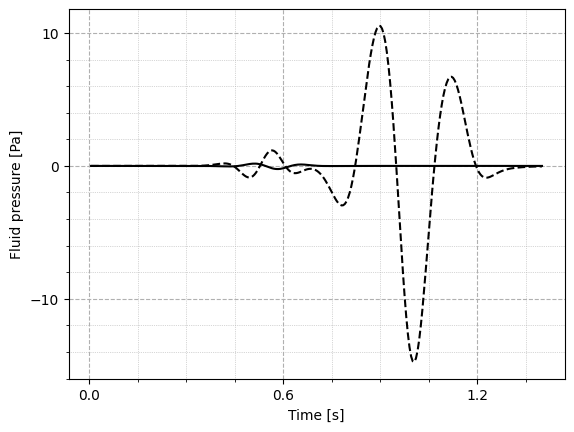

In [4]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(time_values, pressure0, color='black', linestyle='--')
plt.plot(time_values, pressure, color='black', linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Fluid pressure [Pa]')
plt.grid(True, which='both', linestyle='--')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(3))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.show()

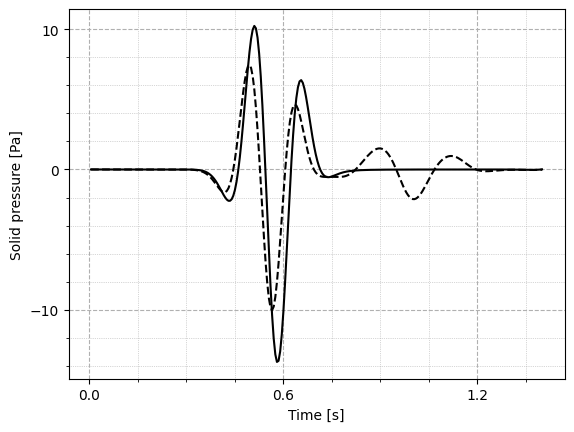

In [5]:
plt.figure()
plt.plot(time_values, Spressure0, color='black', linestyle='--', label='Inviscid model')
plt.plot(time_values, Spressure, color='black', linestyle='-', label='Viscous model')
plt.xlabel('Time [s]')
plt.ylabel('Solid pressure [Pa]')
plt.grid(True, which='both', linestyle='--')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(3))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
#plt.legend()
plt.show()

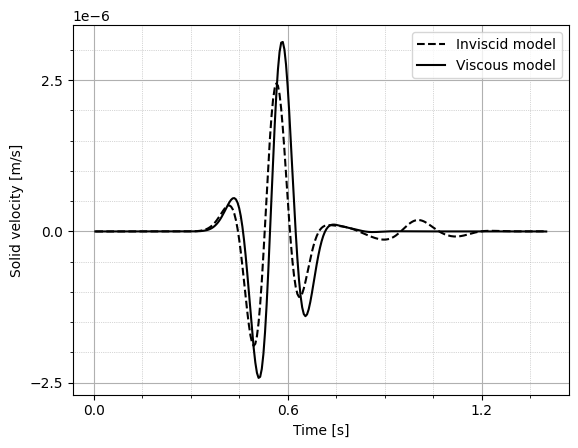

In [6]:
plt.figure()
plt.plot(time_values, velocityS0_values, color='black', linestyle='--', label='Inviscid model')
plt.plot(time_values, velocityS_values, color='black', linestyle='-', label='Viscous model')
plt.xlabel('Time [s]')
plt.ylabel('Solid velocity [m/s]')
plt.grid(True, which='both')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(3))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
plt.legend()
plt.show()

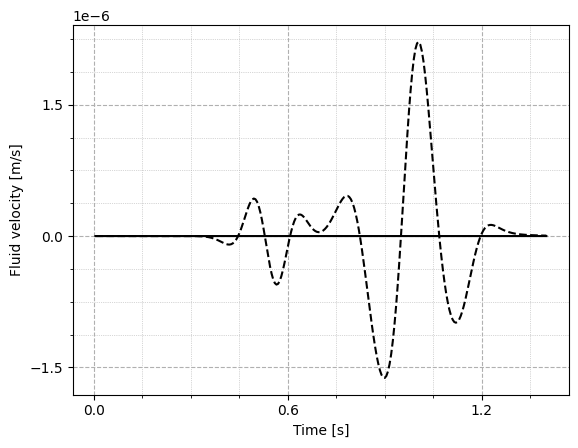

In [7]:
plt.figure()
plt.plot(time_values, velocityF0_values, color='black', linestyle='--')
plt.plot(time_values, velocityF_values, color='black', linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Fluid velocity [m/s]')
plt.grid(True, which='both', linestyle='--')
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(3))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(3))
#plt.legend()
plt.show()